In [52]:
import os
import cv2
import copy
import json
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

In [1]:
# TensorFlow and tf.keras
import json
import random
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Load Stanford Dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [3]:
# 데이터셋에서 클래스 수 가져오기
num_classes = ds_info.features["label"].num_classes

In [4]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [5]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [6]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# mix two labels
def mix_2_labels(label_a, label_b, mixed_img, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = mixed_img.shape[1]
    image_size_y = mixed_img.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [9]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, image_a, x_min, y_min, x_max, y_max))
        
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_cutmix=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.map(onehot, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix: ds = ds.map(cutmix, num_parallel_calls=2)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
BATCH_SIZE = 16

In [12]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)

In [19]:
ds_test_cutmix = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE, is_test=False, with_cutmix=False)

## 모델 준비하기

In [11]:
# ResNet50 모델 불러오기 (Imagenet 가중치 사용)
base_model = ResNet50(
    include_top=False,  # Imagenet 분류기(fully connected layer) 제거
    weights=None,
    input_shape=(224, 224, 3)
)

# 새로운 모델 구성
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # 4D 텐서를 2D로 변환
preds = layers.Dense(num_classes, activation='softmax', use_bias=False)(x)  # softmax 활성화 함수 사용

# 최종 모델 (ResNet50의 입력과 preds를 연결)
cam_model = Model(inputs=base_model.input, outputs=preds)

# 모델 요약
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [16]:
# Compile Model
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

# Train Model with CutMix
history_cam_model = cam_model.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_test_cutmix,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=50,
    verbose=1
)

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 224, 224, 3), found shape=(224, 224, 3)


In [7]:
# 모델 저장
cam_model.save('cam_model_sqc_resnet_cutmix.h5')
cam_model.save_weights('cam_model_sqc_resnet_cutmix_weights.h5')

# History 저장
with open('history_cutmix_cam_model.json', 'w') as f:
    pd.DataFrame(history_cam_model.history).to_json(f)
    
def history_conv(history):
    return_history = {'loss' : list(history['loss'].values()),
                      'accuracy' : list(history['accuracy'].values()),
                      'val_loss' : list(history['val_loss'].values()),
                      'val_accuracy' : list(history['val_accuracy'].values())}
    return return_history

with open('history_cutmix_cam_model.json', 'r') as f:
    history_cam_model = json.load(f)
    history_cam_model = history_conv(history_cam_model)

100


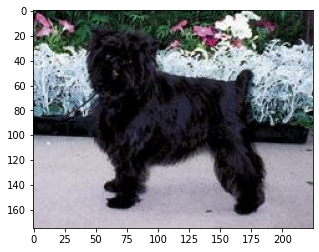

In [27]:
# CAM정의
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [28]:
# CAM function
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

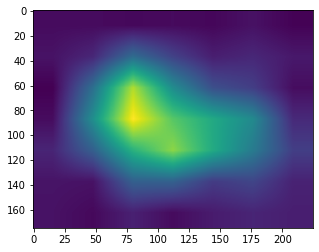

In [29]:
# CAM 계산 및 시각화
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [30]:
#원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수 

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

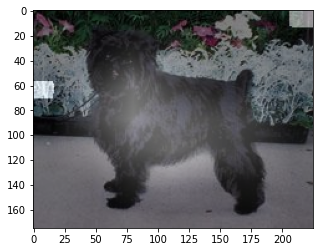

In [31]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

71


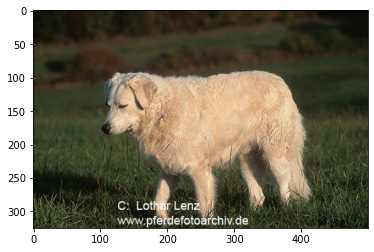

In [32]:
# Grad-CAM 구현

# 데이터 준비
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()


In [33]:
# Grad-CAM function
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(activation_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        loss = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0]

    weights = np.mean(grad_val, axis=(0, 1))
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[1:3])

    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = cv2.resize(grad_cam_image.numpy(), (width, height))
    return grad_cam_image

In [39]:
# # ds_test 데이터에서 하나의 이미지를 선택
# for data in ds_test.take(1):
#     item = data  # 데이터 구조에 따라 적절히 수정 (예: data, data[0], data['image'])

# # 여러 레이어의 Grad-CAM 이미지 생성
# grad_cam_layers = ['conv5_block3_out', 'conv4_block3_out', 'conv3_block3_out', 'conv2_block3_out']

# for layer in grad_cam_layers:
#     grad_cam_image = generate_grad_cam(cam_model, layer, item)
#     plt.imshow(grad_cam_image)
#     plt.title(f'Grad-CAM {layer}')
#     plt.axis('off')
#     plt.show()



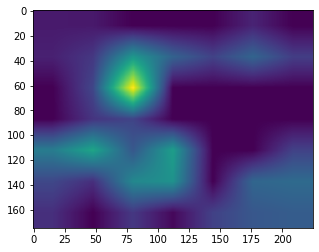

In [40]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [41]:
# 이미지 시각화
origin_grad_image = item['image'].astype(np.uint8)
grad_cam_image = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_grad_image = visualize_cam_on_image(grad_cam_image, origin_grad_image)
plt.imshow(blended_grad_image)
plt.show()

AttributeError: 
        'EagerTensor' object has no attribute 'astype'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

In [24]:
def visualize_cam_on_image(cam_image, original_image):

    # Ensure the Grad-CAM image is in 3-channel format (RGB)
    if len(cam_image.shape) == 2:  # If it's a single channel image (grayscale)
        cam_image = np.dstack([cam_image] * 3)  # Convert it to 3-channel
    
    # Ensure the original image is a numpy array and in RGB format
    original_image = np.array(original_image)
    if original_image.shape[-1] == 1:  # If the image is grayscale
        original_image = np.dstack([original_image] * 3)  # Convert to RGB
    
    # Resize cam_image to match the original image size (if necessary)
    cam_image_resized = cv2.resize(cam_image, (original_image.shape[1], original_image.shape[0]))
    
    # Normalize the original image to [0, 255] if it's not already in that range
    if original_image.max() <= 1:
        original_image = np.uint8(original_image * 255)
    
    # Blend Grad-CAM with original image
    alpha = 0.4  # The transparency of the heatmap over the original image
    blended_image = cv2.addWeighted(original_image, 1 - alpha, cam_image_resized, alpha, 0)
    
    return blended_image

# Example usage
grad_cam_image = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)

# Ensure origin_grad_image is already loaded or set
# origin_grad_image = ... # load your original image here

# Check if origin_grad_image is properly loaded
if origin_grad_image is None:
    raise ValueError("Original image (origin_grad_image) is not loaded properly.")

blended_grad_image = visualize_cam_on_image(grad_cam_image, origin_grad_image)

# Display the result
plt.imshow(blended_grad_image)
plt.title('Blended Grad-CAM')
plt.axis('off')
plt.show()


error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:647: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [17]:

# 3. 이미지 시각화

origin_grad_image = item['image']
grad_cam_image = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_grad_image = visualize_cam_on_image(grad_cam_image, origin_grad_image)
plt.imshow(blended_grad_image)
plt.title('Blended Grad-CAM') 
plt.axis('off')
plt.show()



NameError: name 'visualize_cam_on_image' is not defined

In [ ]:
# 바운딩 박스 구하기
# 1. 바운딩 박스
# 데이터 준비
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.imshow('CAM Image')
plt.axis('off')
plt.show()

# 바운딩 박스 구하기
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
	returen None
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

rect = get_bbox(cam_image)
if rect is not None:
    print(rect)

    # 원본 이미지에 바운딩 박스 표시
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
    plt.imshow(image)
    plt.title('Image with Bounding Box') 
    plt.axis('off'
    plt.show()

In [ ]:
# IoU Calculation
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [ ]:
iou_score = get_iou(pred_bbox, treu_bbox)
print(f"IoU score: {iou_score:.4f}"
